C:\Users\91637\AppData\Local\Temp\ipykernel_4084\2866707212.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X).unsqueeze(-1).float(), torch.tensor(Y).unsqueeze(-1).float(), scaler


Epoch [10/100], Loss: 0.1082
Epoch [20/100], Loss: 0.0723
Epoch [30/100], Loss: 0.0364
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0062
Epoch [60/100], Loss: 0.0036
Epoch [70/100], Loss: 0.0018
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0001

Test MSE Loss: 0.0001


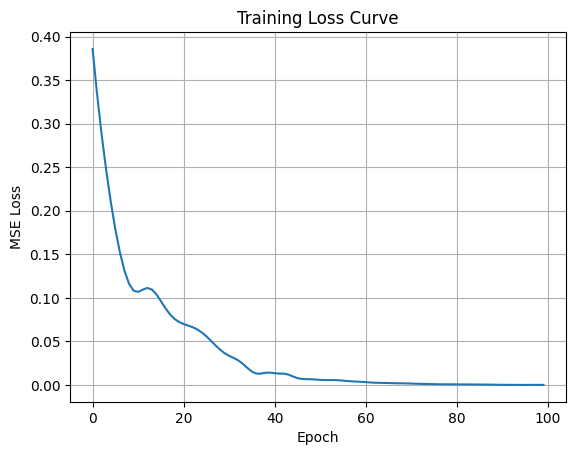

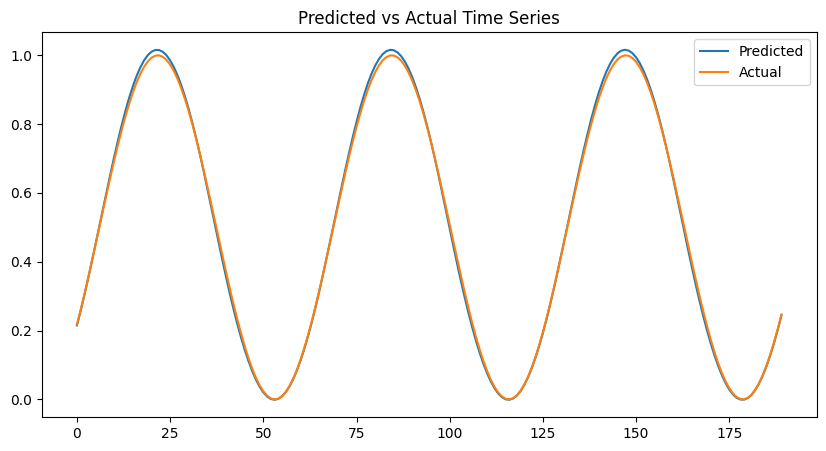

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Generate sine wave dataset
def generate_data(seq_length=50):
    x = np.linspace(0, 100, 1000)
    y = np.sin(x)
    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
    X, Y = [], []
    for i in range(len(y_scaled) - seq_length):
        X.append(y_scaled[i:i+seq_length])
        Y.append(y_scaled[i+seq_length])
    return torch.tensor(X).unsqueeze(-1).float(), torch.tensor(Y).unsqueeze(-1).float(), scaler

# Define the RNN model
class RNNPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(RNNPredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # take output from last time step
        return self.fc(out)

# Hyperparameters
seq_length = 50
lr = 0.001
epochs = 100

# Data preparation
X, Y, scaler = generate_data(seq_length)
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Model, Loss, Optimizer
model = RNNPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    pred = model(X_test)
    test_loss = criterion(pred, Y_test)
    print(f"\nTest MSE Loss: {test_loss.item():.4f}")

# Plot Loss Curve
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

# Plot Prediction vs Actual
pred_numpy = pred.detach().numpy()
Y_test_numpy = Y_test.detach().numpy()
plt.figure(figsize=(10, 5))
plt.plot(pred_numpy, label='Predicted')
plt.plot(Y_test_numpy, label='Actual')
plt.title("Predicted vs Actual Time Series")
plt.legend()
plt.show()
